In [40]:
# from statsmodels.regression.rolling import RollingOLS
# import pandas_datareader.data as web
# import matplotlib.pyplot as plt
# import statsmodels.api as sm
# import pandas as pd
# import numpy as np
# import datetime as dt
# import yfinance as yf
# import pandas_ta

# import warnings
# warnings.filterwarnings('ignore')

# sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

# sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

# symbols_list = sp500['Symbol'].unique().tolist()

# end_date = '2023-09-27'

# start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

# df = yf.download(tickers=symbols_list,
#                  start=start_date,
#                  end=end_date).stack()

# df.index.names = ['date', 'ticker']

# df.columns = df.columns.str.lower()

# df


In [41]:
# Calculate features and technical indicators per stock
# Garman-Klass Volatility
# RSI
# Bollinger Bands
# ATR
# MACD
# Dollar Volume

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                          
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.483557   33.740002   34.060001   33.240002   33.360001   
           AAL      37.361614   39.180000   39.770000   38.790001   39.049999   
           AAPL     24.651131   27.264999   28.377501   26.965000   28.207500   
           ABBV     36.334904   52.790001   54.189999   51.880001   53.099998   
           ABT      33.478703   39.500000   40.150002   39.029999   39.259998   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYL      88.968475   89.519997   90.849998   89.500000   90.379997   
           YUM     122.811577  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.782722  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     175.547699  176.869995  178.449997  176.270004  176.580002   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2015-09-29 A         2252400.0         -0.000998        NaN       NaN   
           AAL       7478800.0         -0.000443        NaN       NaN   
           AAPL    293461600.0         -0.005712        NaN       NaN   
           ABBV     12842800.0         -0.054655        NaN       NaN   
           ABT      12287500.0         -0.009402        NaN       NaN   
...                        ...               ...        ...       ...   
2023-09-26 XYL       1322400.0          0.000016  26.146751  4.488345   
           YUM       1500600.0          0.000002  36.057164  4.816569   
           ZBH       3610500.0          0.000099  31.893231  4.748085   
           ZBRA       355400.0          0.000133  29.494977  5.400991   
           ZTS       1463200.0          0.000062  42.623467  5.156108   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2015-09-29 A            NaN       NaN       NaN       NaN      70.913563  
           AAL          NaN       NaN       NaN       NaN     279.420040  
           AAPL         NaN       NaN       NaN       NaN    7234.160250  
           ABBV         NaN       NaN       NaN       NaN     466.641901  
           ABT          NaN       NaN       NaN       NaN     411.369558  
...                     ...       ...       ...       ...            ...  
2023-09-26 XYL     4.570270  4.652196  0.033800 -2.159188     117.651912  
           YUM     4.846536  4.876502  0.142547 -1.363695     184.291052  
           ZBH     4.787752  4.827420 -0.381708 -0.881067     403.591519  
           ZBRA    5.539167  5.677342 -0.057389 -1.600791      79.595386  
           ZTS     5.214922  5.273735  0.651515 -1.188279     256.861393  

[988898 rows x 14 columns]

In [51]:
# Filter top 150 most liquid stocks for each month

last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

data


dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2015-11-30 A          135.992828   39.023178         -0.001992  73.421414   
           AAL        287.915788   39.429935         -0.000966  40.719012   
           AAPL      4023.983957   26.854143         -0.003307  55.537380   
           ABBV       337.563918   40.393539         -0.059549  49.376907   
           ABT        211.659054   38.293564         -0.011216  56.962555   
...                          ...         ...               ...        ...   
2023-09-30 OTIS       154.983158   78.671936         -0.000020  33.116219   
           ABNB      1633.500725  132.279999          0.000213  44.494127   
           CEG        196.971016  108.026917          0.000171  55.245482   
           GEHC       212.275852   66.130219          0.000185  40.922338   
           KVUE       670.804304   20.006193         -0.000159  35.706312   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2015-11-30 A       3.545992  3.618440  3.690888 -1.033887  0.567156  
           AAL     3.672028  3.749832  3.827635  0.190822 -0.418772  
           AAPL    3.281679  3.324991  3.368302 -0.967900 -0.142789  
           ABBV    3.726695  3.774943  3.823191 -0.526809  0.145677  
           ABT     3.656055  3.677909  3.699763 -1.064842  0.335558  
...                     ...       ...       ...       ...       ...  
2023-09-30 OTIS    4.374104  4.419394  4.464683 -1.028320 -1.534536  
           ABNB    4.857047  4.940924  5.024801 -1.006939 -0.037854  
           CEG     4.653660  4.693834  4.734007 -0.436215  0.366876  
           GEHC    4.155436  4.212972  4.270508 -0.893478 -1.116463  
           KVUE    3.014275  3.089221  3.164168 -0.899746 -1.435621  

[46692 rows x 9 columns]

In [43]:
# Calulate the 5 year rolling average dollar volume for each stock 

data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2016-10-31 AAL      39.134327         -0.000176  62.203519  3.604673   
           AAPL     26.212471         -0.002468  49.891046  3.294237   
           ABBV     40.245121         -0.046691  27.477809  3.753446   
           ABT      34.293457         -0.007492  38.008861  3.554632   
           ACN     103.569618         -0.004643  53.823646  4.637342   
...                       ...               ...        ...       ...   
2023-09-30 WMT      53.783058         -0.000011  54.722524  3.988367   
           XOM     114.292961          0.000026  59.440189  4.695106   
           MRNA     98.120003          0.000146  38.747314  4.582514   
           UBER     44.270000          0.000441  45.005268  3.806654   
           ABNB    132.279999          0.000213  44.494127  4.857047   

                     bb_mid   bb_high       atr      macd  
date       ticker                                          
2016-10-31 AAL     3.655494  3.706314  0.402199  1.131596  
           AAPL    3.323117  3.351997 -1.038688 -0.195978  
           ABBV    3.807610  3.861774 -0.893132 -0.760593  
           ABT     3.605106  3.655580 -1.035224 -0.650889  
           ACN     4.648980  4.660617 -0.996806 -0.135457  
...                     ...       ...       ...       ...  
2023-09-30 WMT     4.005838  4.023309 -0.196381  0.399458  
           XOM     4.735205  4.775304  0.601335  1.400623  
           MRNA    4.685332  4.788149 -0.529511 -0.376899  
           UBER    3.862227  3.917801 -0.746098 -0.133973  
           ABNB    4.940924  5.024801 -1.006939 -0.037854  

[12516 rows x 8 columns]

In [44]:
# Calculate monthly returns for different horizon as features

# Use lags for 1, 2, 3, 6, 9, 12 months gives 6 different lags

def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
    
    
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2017-10-31 AAL      45.534164         -0.000363  41.051759  3.849110   
           AAPL     39.713898         -0.001055  69.196686  3.594730   
           ABBV     67.491165         -0.034008  55.247942  4.196702   
           ABT      48.493382         -0.005190  53.844927  3.892568   
           ACN     129.399704         -0.003925  69.365140  4.802675   
...                       ...               ...        ...       ...   
2023-09-30 WMT      53.783058         -0.000011  54.722524  3.988367   
           XOM     114.292961          0.000026  59.440189  4.695106   
           MRNA     98.120003          0.000146  38.747314  4.582514   
           UBER     44.270000          0.000441  45.005268  3.806654   
           ABNB    132.279999          0.000213  44.494127  4.857047   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2017-10-31 AAL     3.921750  3.994389  1.011062 -0.018697  -0.014108   
           AAPL    3.641602  3.688475 -0.906642 -0.039276   0.096808   
           ABBV    4.243063  4.289423  0.375557  0.473815   0.022728   
           ABT     3.916137  3.939707 -1.040044  0.276134   0.021276   
           ACN     4.842354  4.882034 -0.986514  0.352342   0.064180   
...                     ...       ...       ...       ...        ...   
2023-09-30 WMT     4.005838  4.023309 -0.196381  0.399458  -0.000676   
           XOM     4.735205  4.775304  0.601335  1.400623   0.046947   
           MRNA    4.685332  4.788149 -0.529511 -0.376899  -0.132219   
           UBER    3.862227  3.917801 -0.746098 -0.133973  -0.062672   
           ABNB    4.940924  5.024801 -1.006939 -0.037854   0.005549   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2017-10-31 AAL      0.022981  -0.023860   0.016495   0.007008    0.012702  
           AAPL     0.015250   0.044955   0.028875   0.038941    0.035228  
           ABBV     0.098590   0.091379   0.056495   0.047273    0.044026  
           ABT      0.034308   0.034801   0.038672   0.031320    0.029294  
           ACN      0.048454   0.037202   0.028692   0.027398    0.018728  
...                      ...        ...        ...        ...         ...  
2023-09-30 WMT      0.010014   0.012354   0.017574   0.016553    0.020256  
           XOM      0.046139   0.030496   0.012838   0.008747    0.027037  
           MRNA    -0.086803  -0.068763  -0.071952  -0.064976   -0.015431  
           UBER    -0.053920   0.008422   0.057244   0.066838    0.043691  
           ABNB    -0.067704   0.010603   0.010289   0.049124    0.019401  

[10346 rows x 14 columns]

In [45]:
# Download Fama-French factors and calculate rolling factor betas

factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data


Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-10-31 AAL     0.0225 -0.0194  0.0020  0.0093 -0.0325  -0.014108
           AAPL    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.096808
           ABBV    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.022728
           ABT     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.021276
           ACN     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.064180
...                   ...     ...     ...     ...     ...        ...
2023-09-30 VRTX   -0.0524 -0.0180  0.0152  0.0186 -0.0083   0.009617
           VZ     -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.056890
           WFC    -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.015500
           WMT    -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.000676
           XOM    -0.0524 -0.0180  0.0152  0.0186 -0.0083   0.046947

[10346 rows x 6 columns]

In [46]:
# Filtering out stocks with less than 10 months of data, as will break our model

observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data



Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-10-31 AAL     0.0225 -0.0194  0.0020  0.0093 -0.0325  -0.014108
           AAPL    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.096808
           ABBV    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.022728
           ABT     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.021276
           ACN     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.064180
...                   ...     ...     ...     ...     ...        ...
2023-09-30 VRTX   -0.0524 -0.0180  0.0152  0.0186 -0.0083   0.009617
           VZ     -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.056890
           WFC    -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.015500
           WMT    -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.000676
           XOM    -0.0524 -0.0180  0.0152  0.0186 -0.0083   0.046947

[10317 rows x 6 columns]

In [47]:
# Now calculate rolling factor betas

betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2017-10-31 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2023-09-30 VRTX    0.456426 -0.445902 -0.312668 -0.079430  0.800286
           VZ      0.332655 -0.165645  0.267344  0.310365  0.106901
           WFC     1.121747  0.300520  2.061533 -0.439491 -1.517557
           WMT     0.700557 -0.315600 -0.413434 -0.142906  0.508472
           XOM     0.983511 -1.093760  1.756776 -0.640868 -0.368454

[10317 rows x 5 columns]

In [52]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

desired_columns = ['atr', 'bb_high', 'bb_low', 'bb_mid', 'garman_klass_vol', 'macd', 'rsi', 'return_1m', 'return_2m', 'return_3m', 'return_6m', 'return_9m', 'return_12m', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

# Ensure the DataFrame has the correct column order
data = data.reindex(columns=desired_columns)

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 14739 entries, (Timestamp('2015-11-30 00:00:00'), 'AAL') to (Timestamp('2023-09-30 00:00:00'), 'UBER')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   atr               14739 non-null  float64
 1   bb_high           14739 non-null  float64
 2   bb_low            14739 non-null  float64
 3   bb_mid            14739 non-null  float64
 4   garman_klass_vol  14739 non-null  float64
 5   macd              14739 non-null  float64
 6   rsi               14739 non-null  float64
 7   return_1m         0 non-null      float64
 8   return_2m         0 non-null      float64
 9   return_3m         0 non-null      float64
 10  return_6m         0 non-null      float64
 11  return_9m         0 non-null      float64
 12  return_12m        0 non-null      float64
 13  Mkt-RF            14739 non-null  float64
 14  SMB               14739 non-null  float64
 15  HML       

In [49]:
# Fitting a KMeans clutstering algorithim for each month, will split stocks into four clusters

from sklearn.cluster import KMeans

def get_clusters(data):
    data['cluster'] = KMeans(n_clusters=4,
                             random_state=0,
                             init='random').fit(data).labels_
    return data

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2017-10-31 AAL            -0.000363  41.051759  3.849110  3.921750  3.994389   
           AAPL           -0.001055  69.196686  3.594730  3.641602  3.688475   
           ABBV           -0.034008  55.247942  4.196702  4.243063  4.289423   
           ABT            -0.005190  53.844927  3.892568  3.916137  3.939707   
           ACN            -0.003925  69.365140  4.802675  4.842354  4.882034   
...                             ...        ...       ...       ...       ...   
2023-09-30 WFC             0.000016  40.920278  3.702645  3.743015  3.783384   
           WMT            -0.000011  54.722524  3.988367  4.005838  4.023309   
           XOM             0.000026  59.440189  4.695106  4.735205  4.775304   
           MRNA            0.000146  38.747314  4.582514  4.685332  4.788149   
           UBER            0.000441  45.005268  3.806654  3.862227  3.917801   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2017-10-31 AAL     1.011062 -0.018697  -0.014108   0.022981  -0.023860   
           AAPL   -0.906642 -0.039276   0.096808   0.015250   0.044955   
           ABBV    0.375557  0.473815   0.022728   0.098590   0.091379   
           ABT    -1.040044  0.276134   0.021276   0.034308   0.034801   
           ACN    -0.986514  0.352342   0.064180   0.048454   0.037202   
...                     ...       ...        ...        ...        ...   
2023-09-30 WFC    -0.558742 -0.282325  -0.015500  -0.057917  -0.013554   
           WMT    -0.196381  0.399458  -0.000676   0.010014   0.012354   
           XOM     0.601335  1.400623   0.046947   0.046139   0.030496   
           MRNA   -0.529511 -0.376899  -0.132219  -0.086803  -0.068763   
           UBER   -0.746098 -0.133973  -0.062672  -0.053920   0.008422   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2017-10-31 AAL      0.016495   0.007008    0.012702  1.265664  1.314316   
           AAPL     0.028875   0.038941    0.035228  1.275749 -0.271695   
           ABBV     0.056495   0.047273    0.044026  0.494523  0.362281   
           ABT      0.038672   0.031320    0.029294  0.828091 -0.199021   
           ACN      0.028692   0.027398    0.018728  1.199047 -0.166700   
...                      ...        ...         ...       ...       ...   
2023-09-30 WFC      0.016712   0.000702    0.003255  1.137640  0.314481   
           WMT      0.017574   0.016553    0.020256  0.740055 -0.261890   
           XOM      0.012838   0.008747    0.027037  1.005969 -1.051371   
           MRNA    -0.071952  -0.064976   -0.015431  1.155154  0.762525   
           UBER     0.057244   0.066838    0.043691  1.078922  1.162540   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2017-10-31 AAL     0.601340  0.458860  0.563294        0  
           AAPL   -0.591145  0.647780  0.458080        1  
           ABBV   -0.033102  0.241980  0.164921        3  
           ABT    -0.529384  0.252407  0.970211        3  
           ACN    -0.328214  0.267791  0.168884        1  
...                     ...       ...       ...      ...  
2023-09-30 WFC     2.009074 -0.404339 -1.468839        3  
           WMT    -0.522678 -0.126426  0.642628        2  
           XOM     1.707833 -0.675681 -0.284024        2  
           MRNA   -1.165677  0.590306  0.993548        3  
           UBER   -0.257003 -1.482231 -0.450323        0  

[10136 rows x 19 columns]

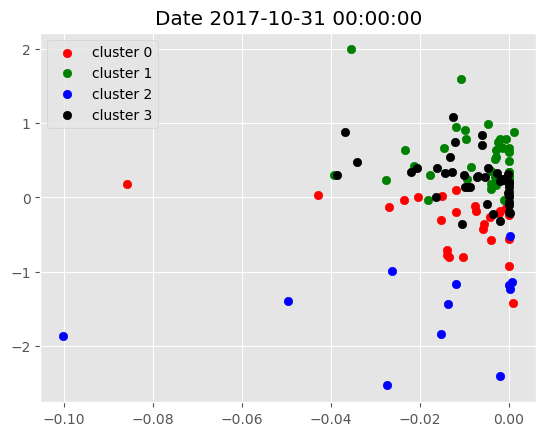

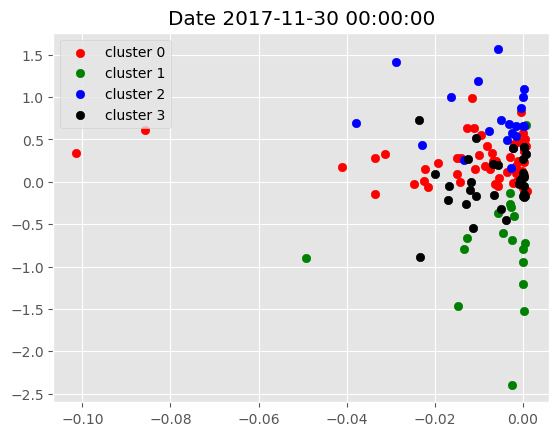

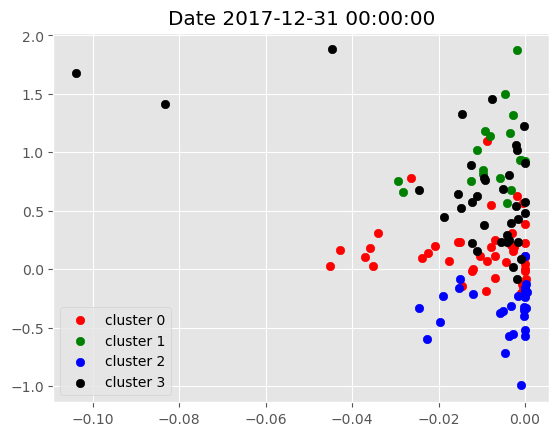

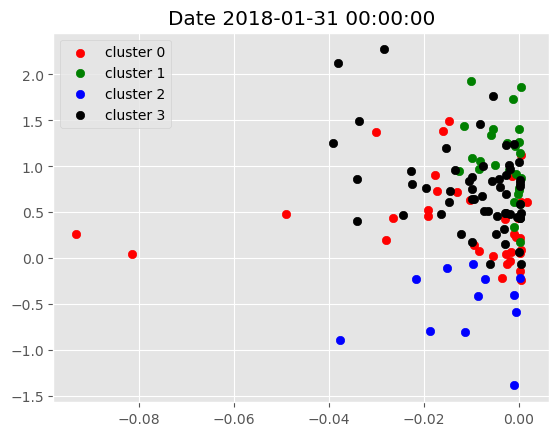

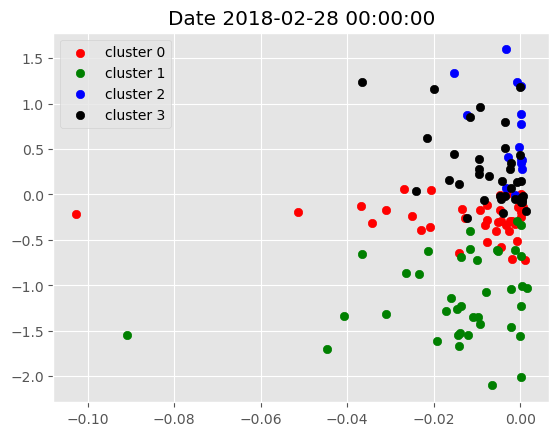

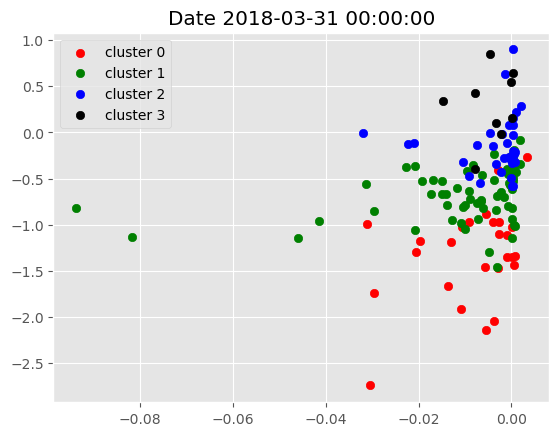

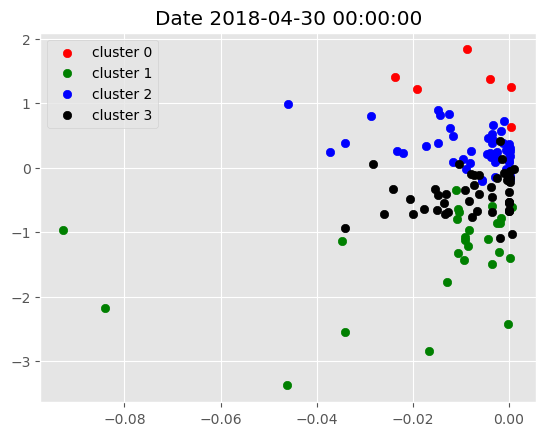

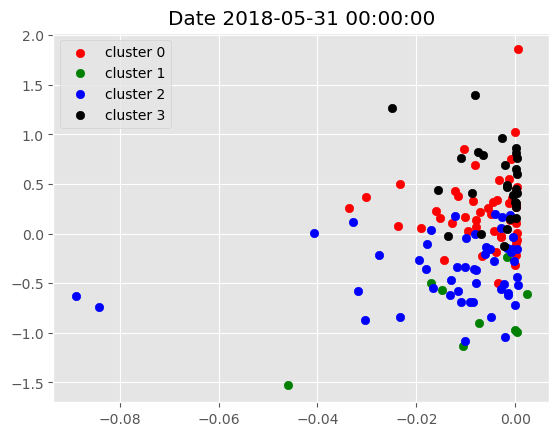

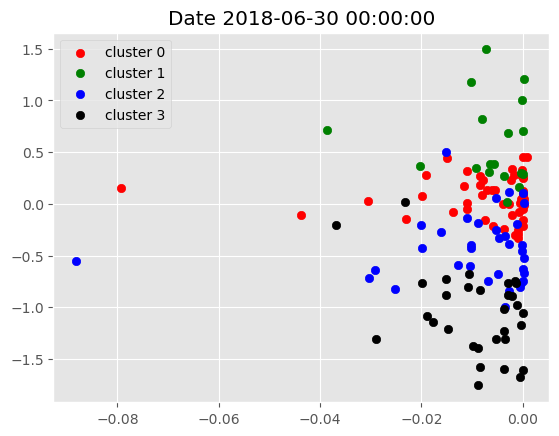

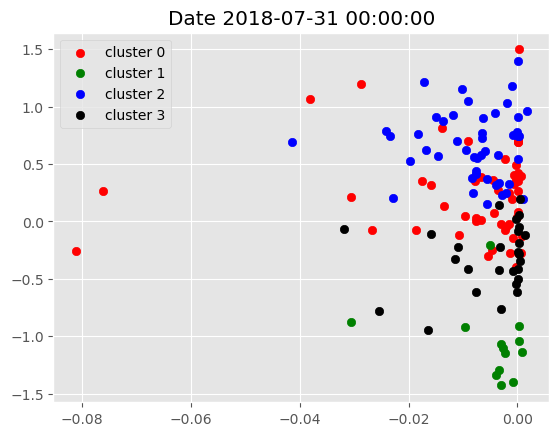

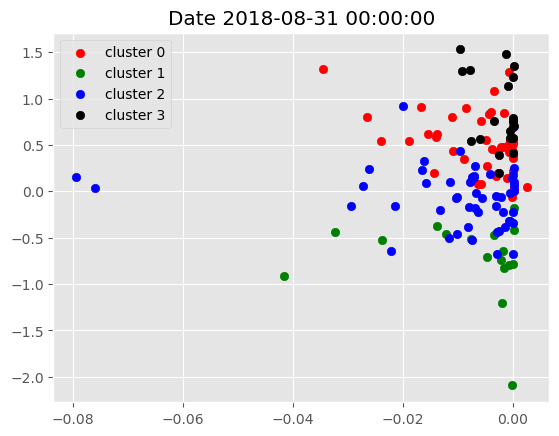

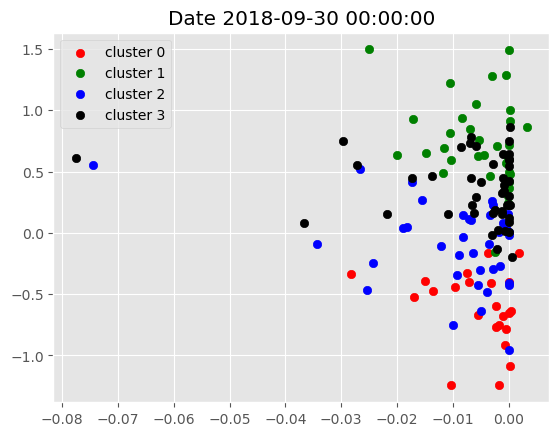

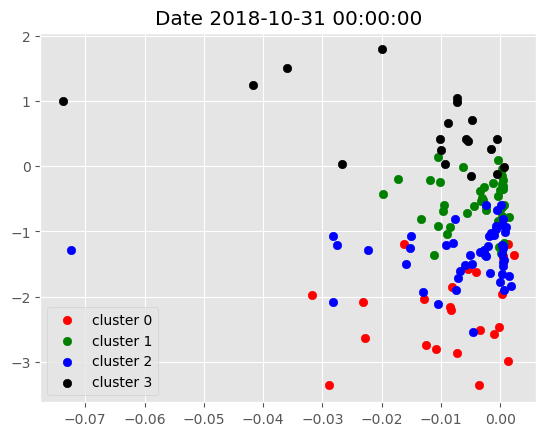

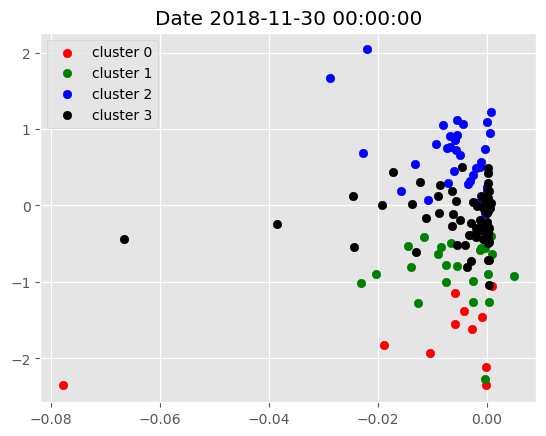

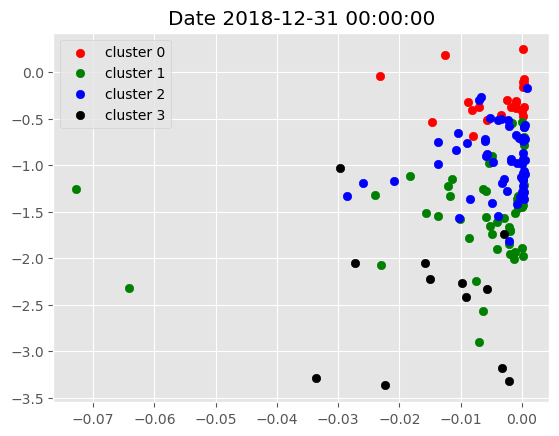

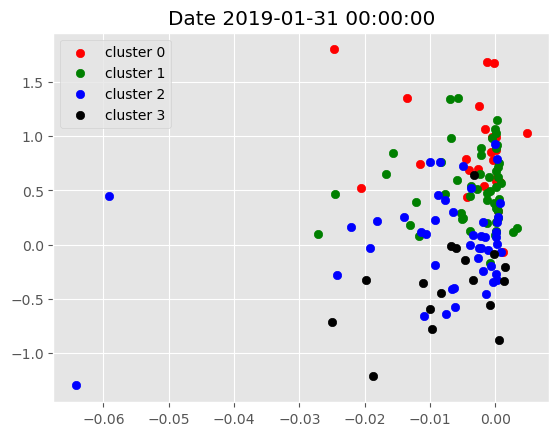

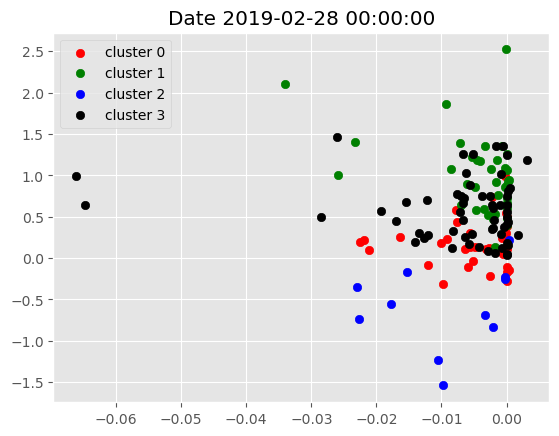

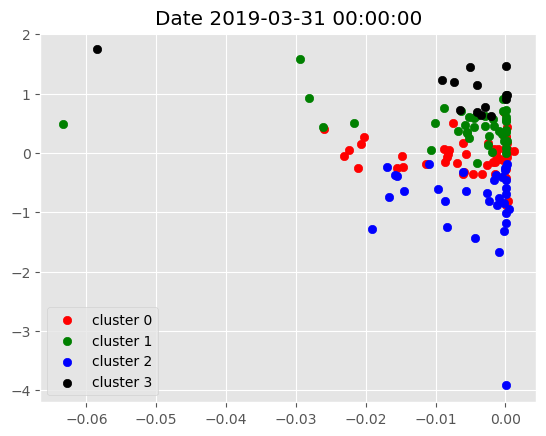

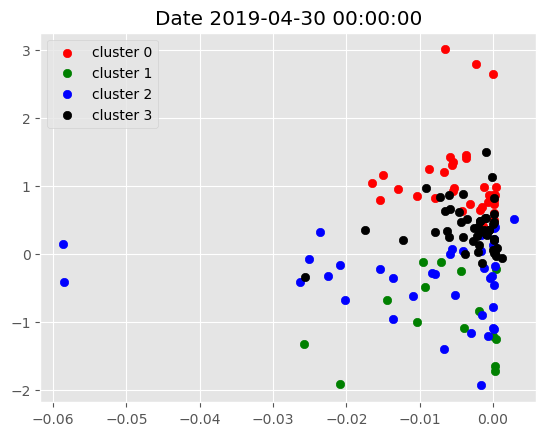

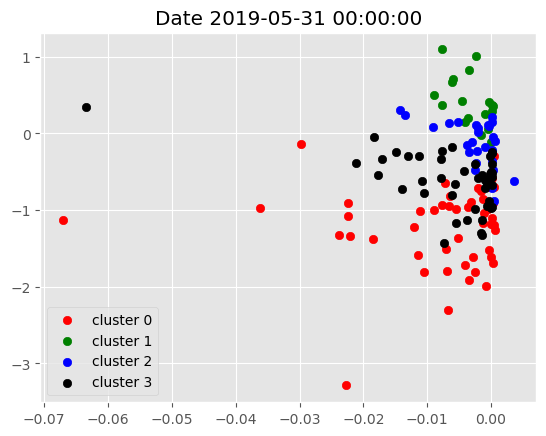

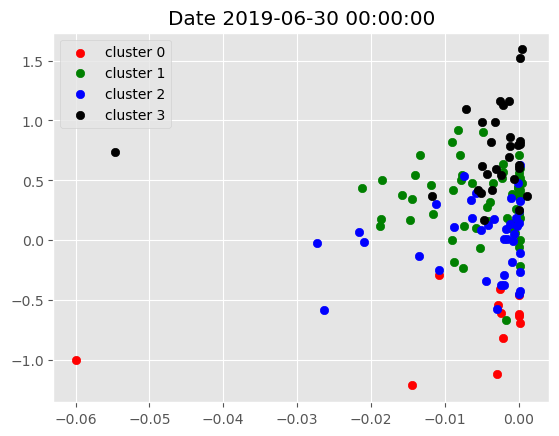

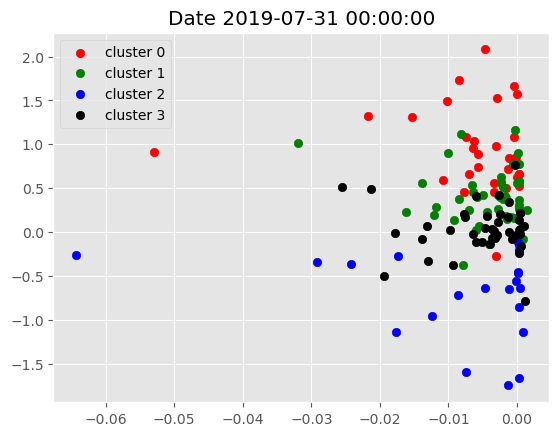

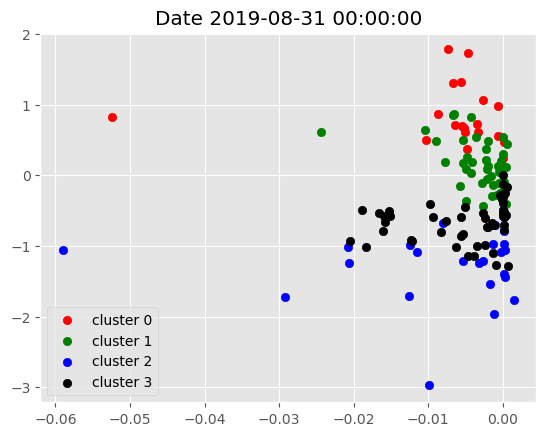

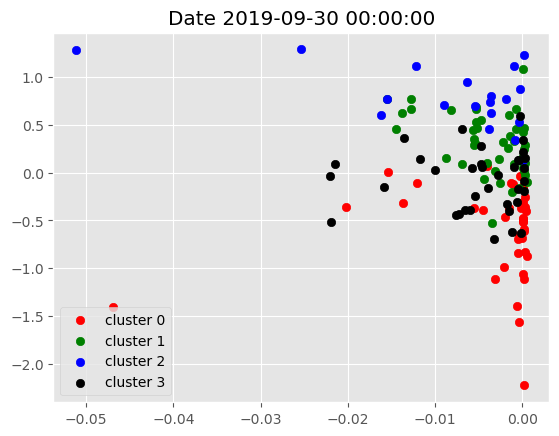

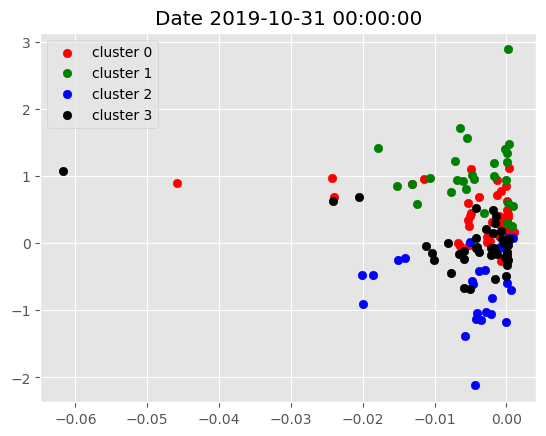

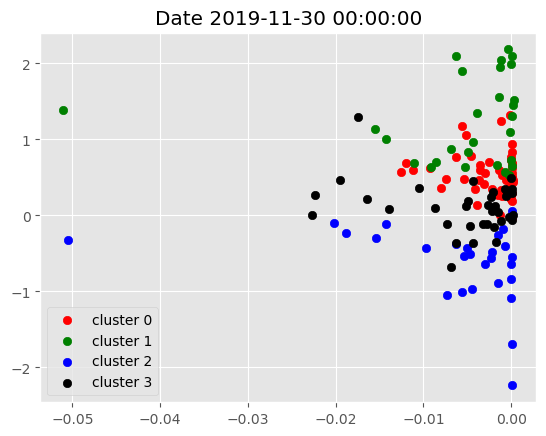

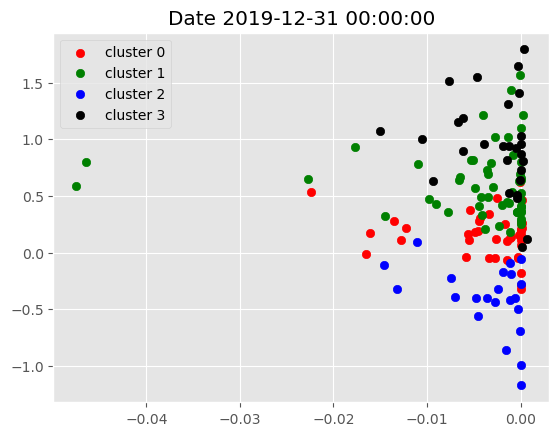

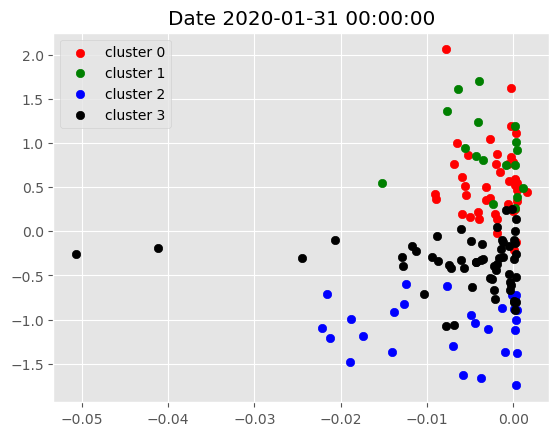

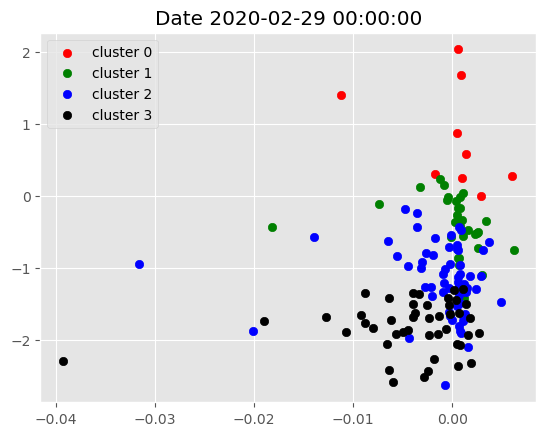

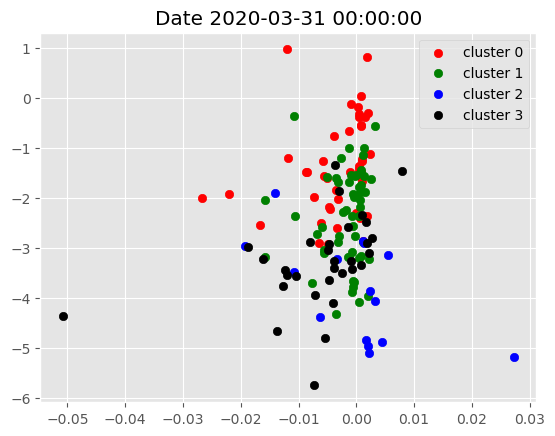

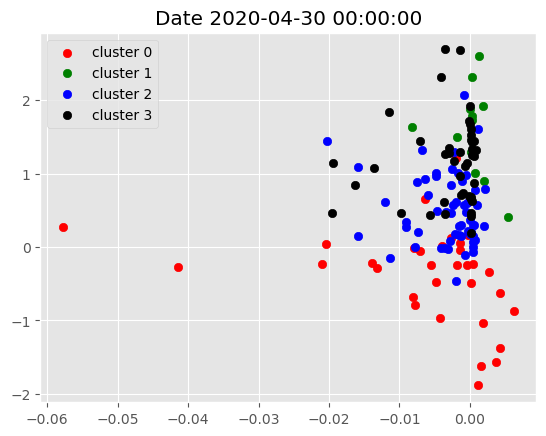

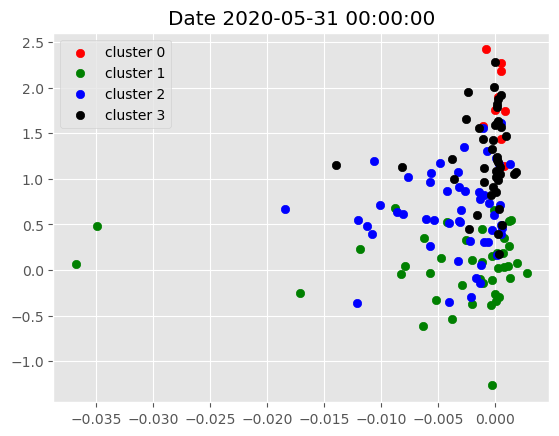

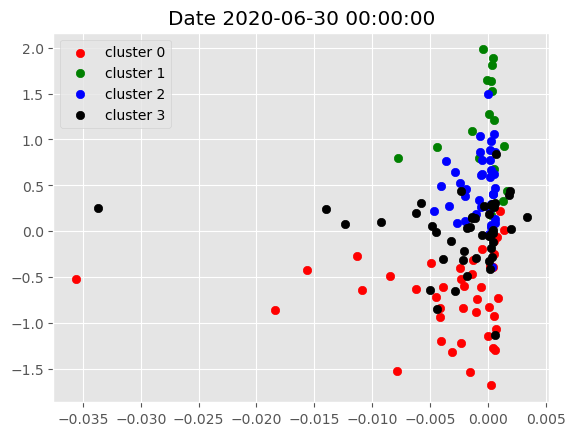

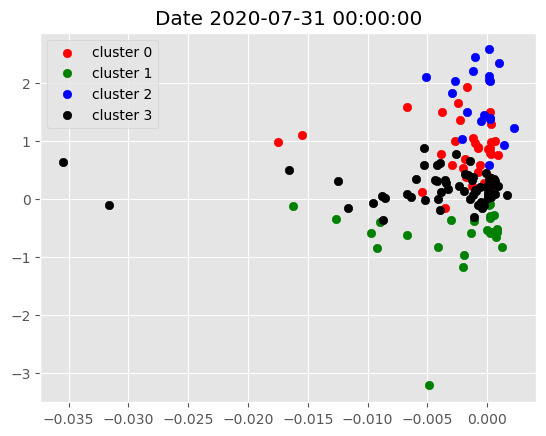

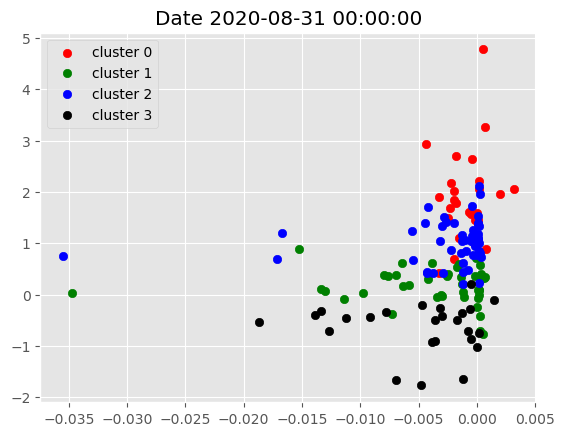

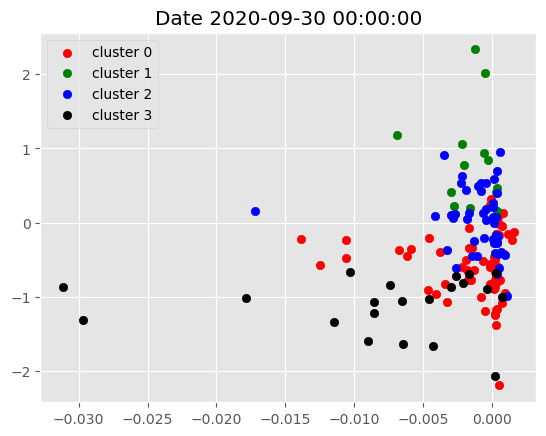

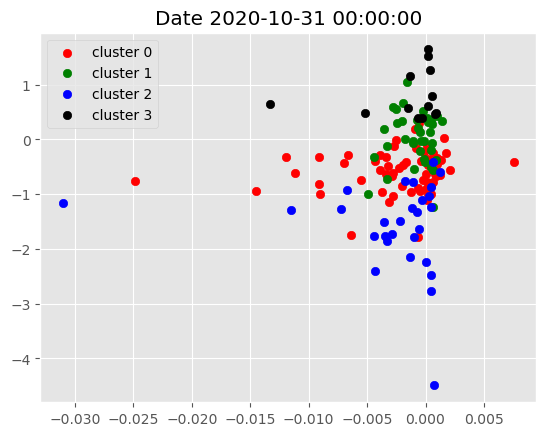

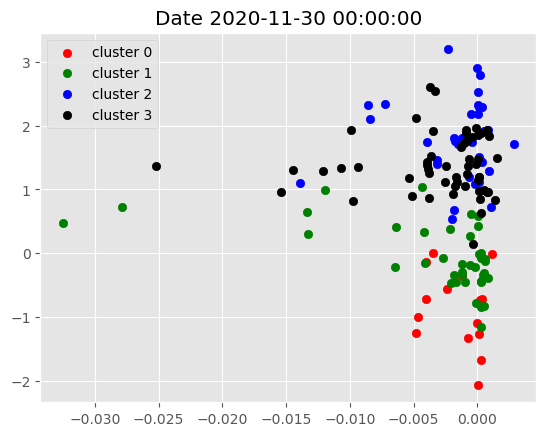

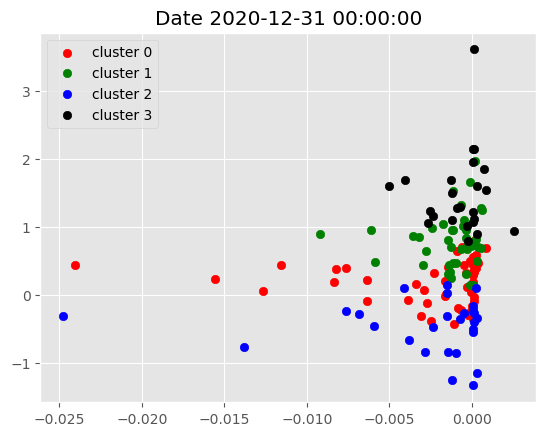

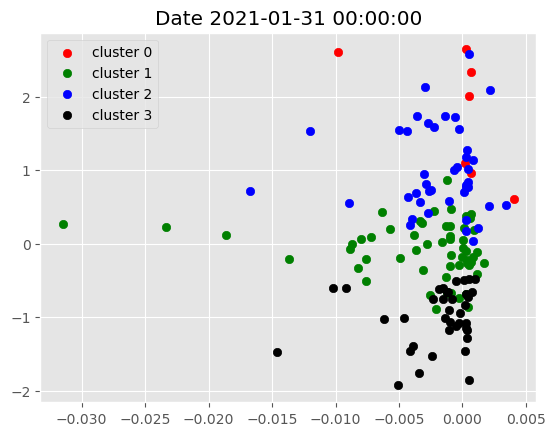

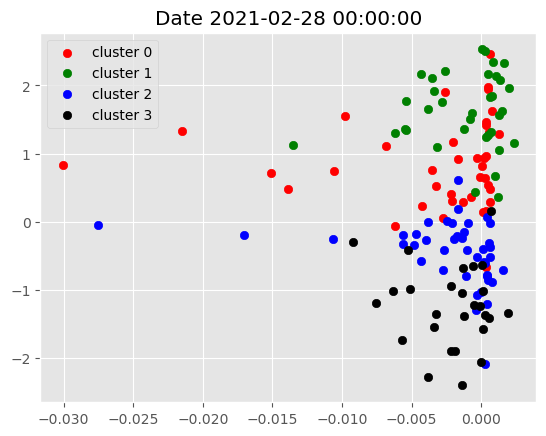

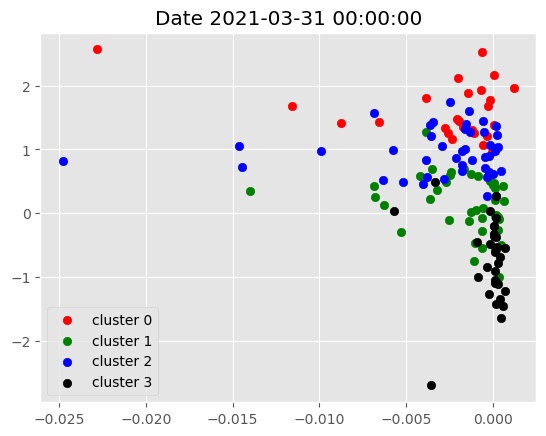

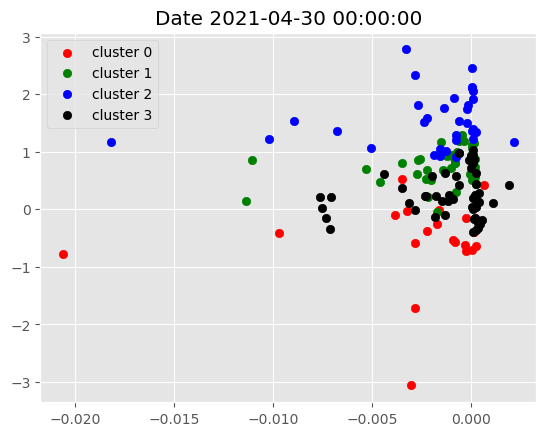

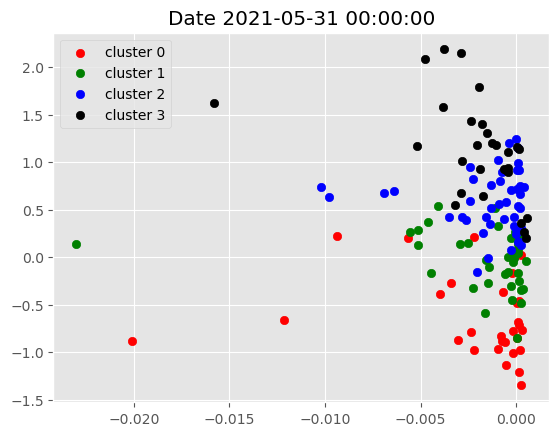

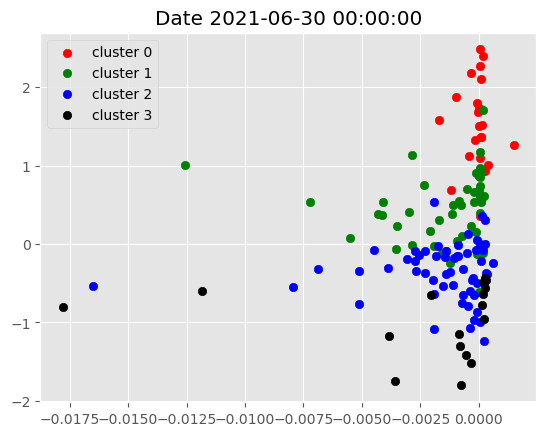

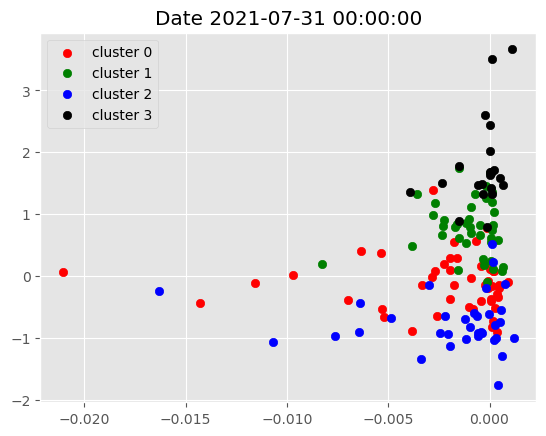

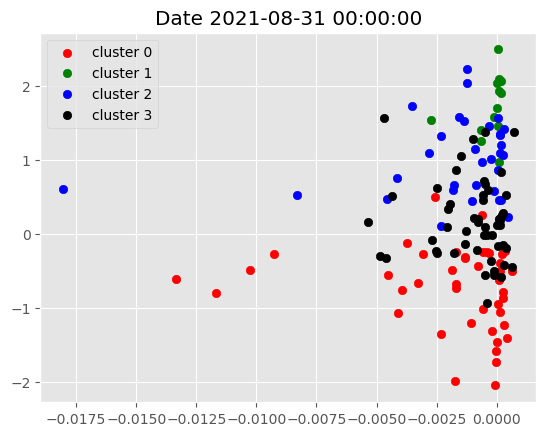

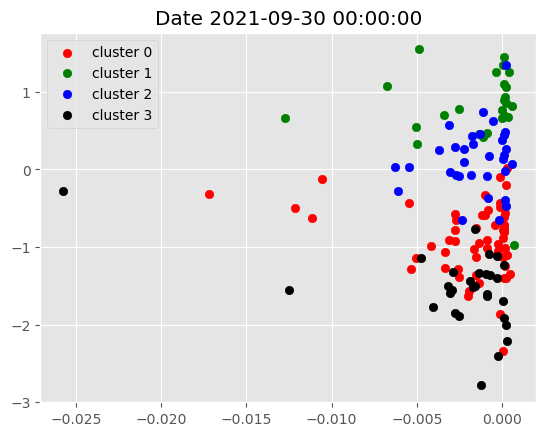

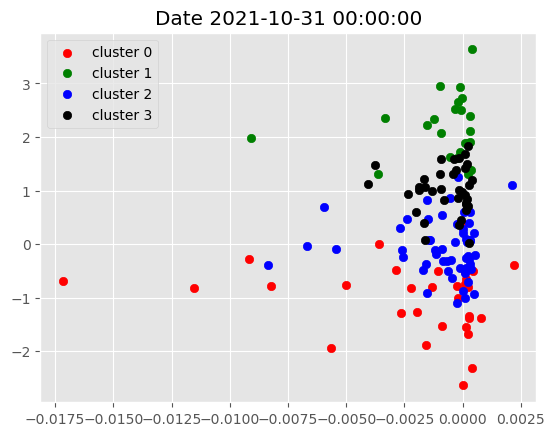

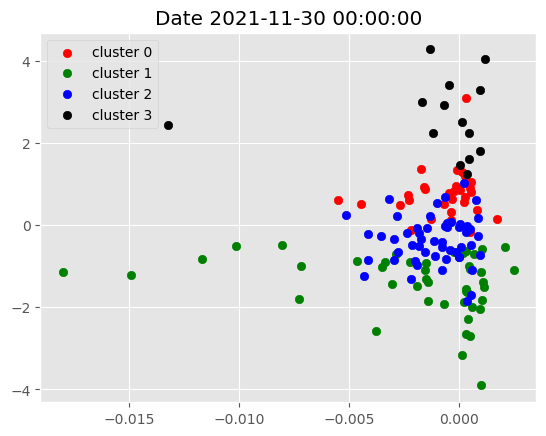

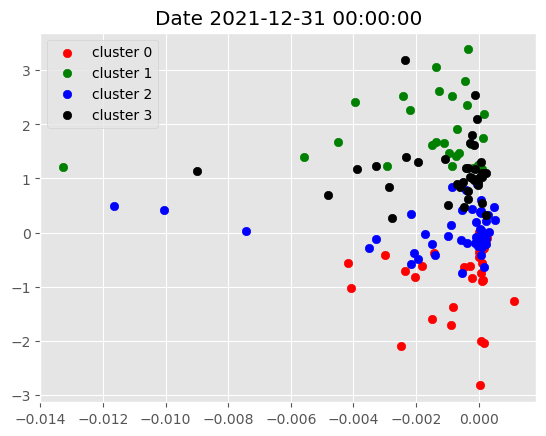

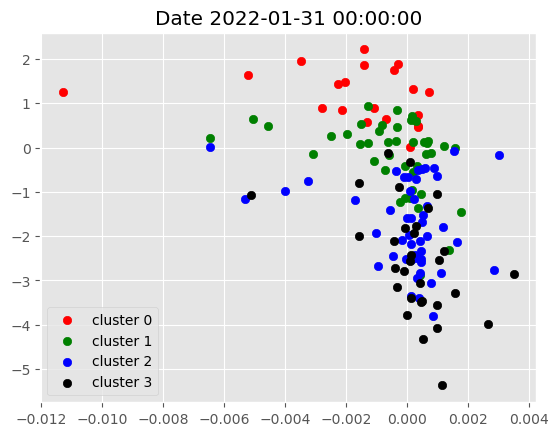

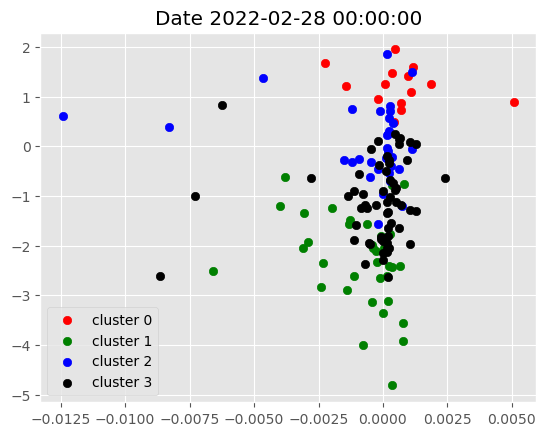

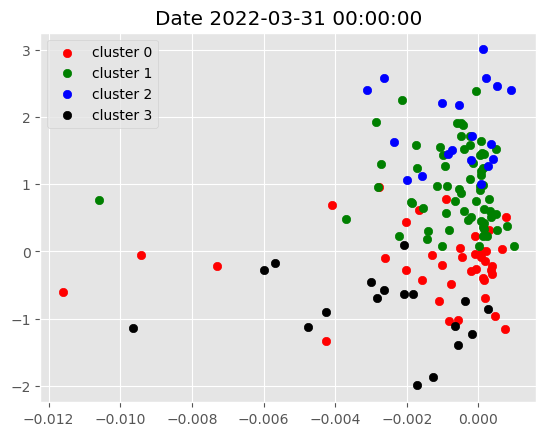

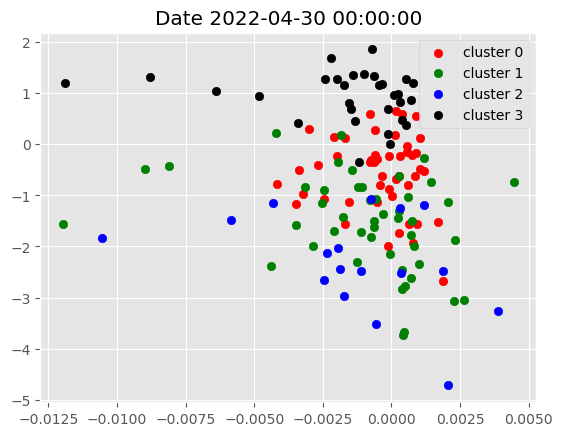

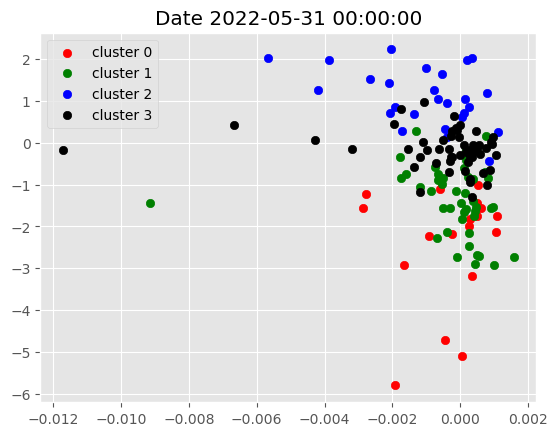

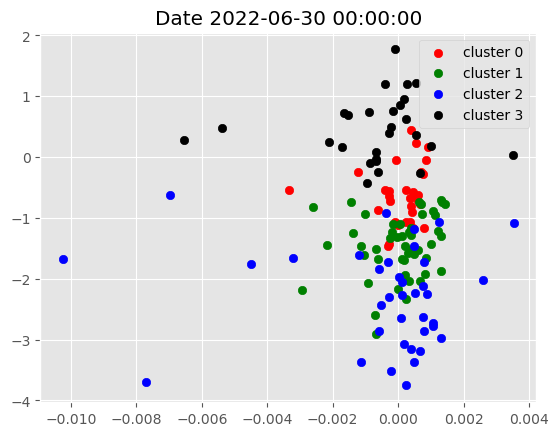

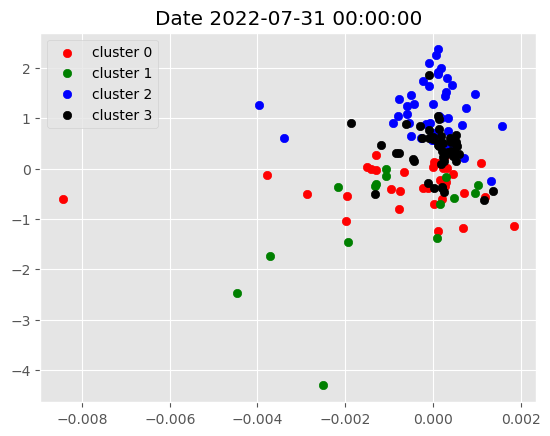

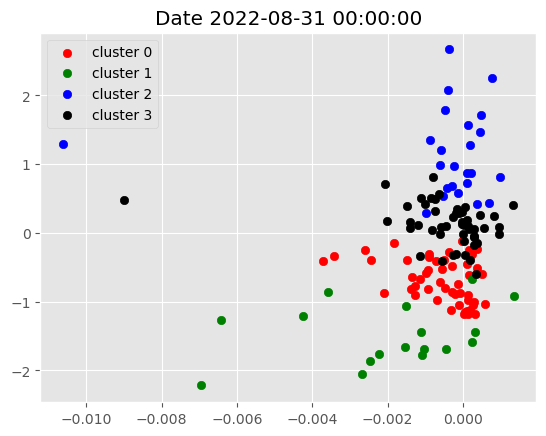

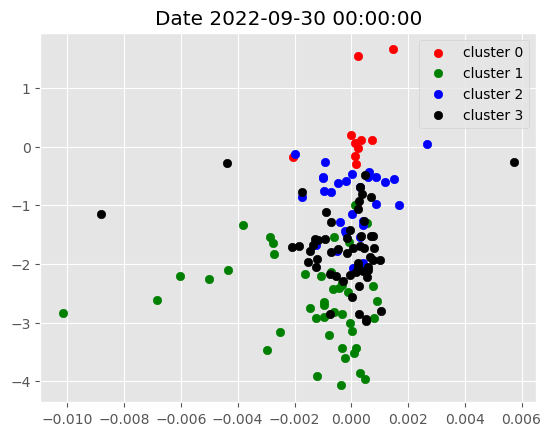

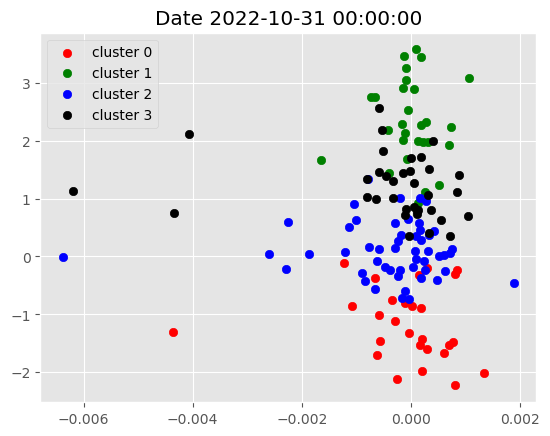

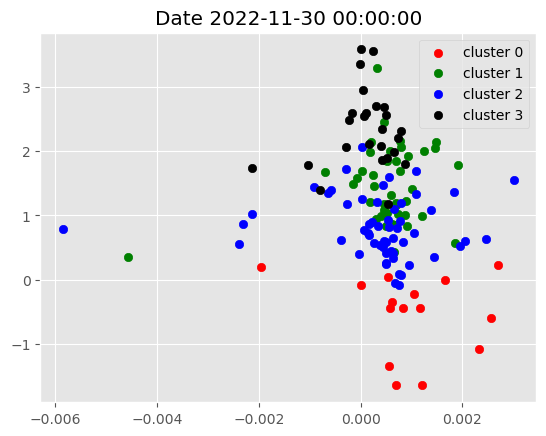

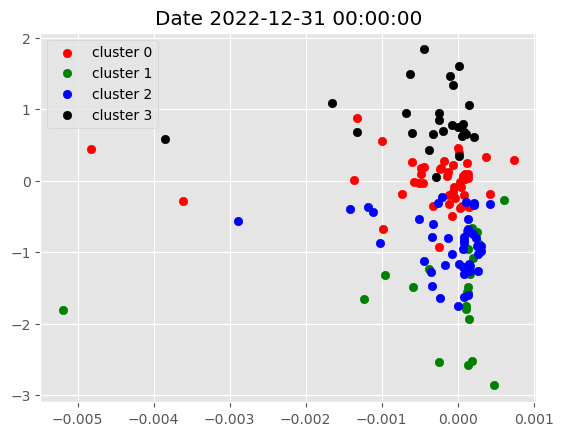

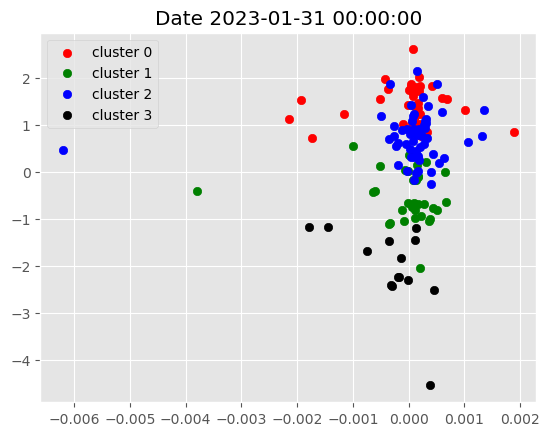

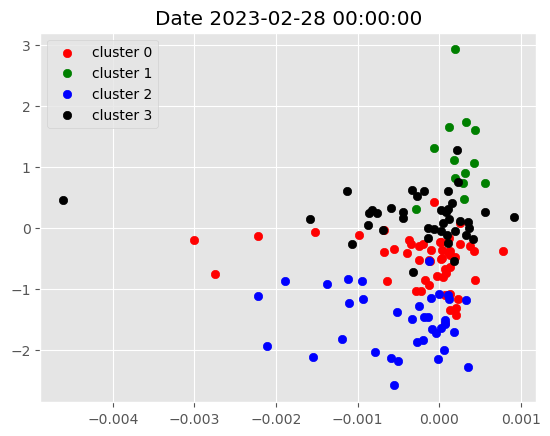

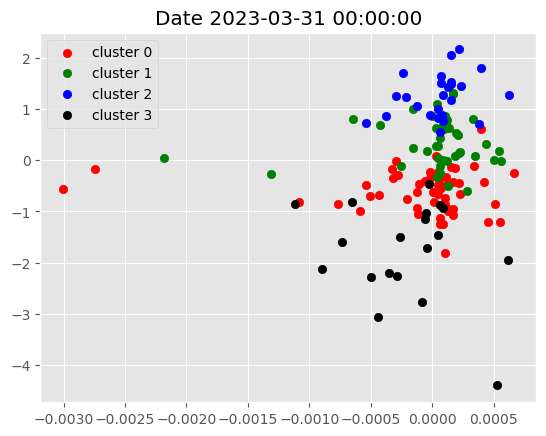

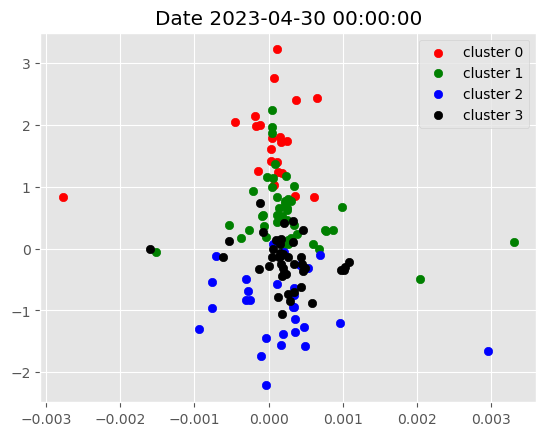

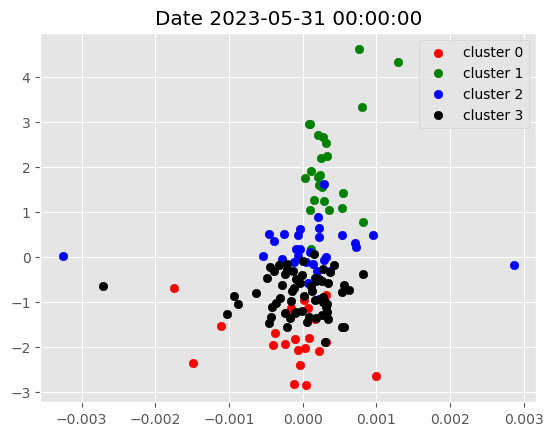

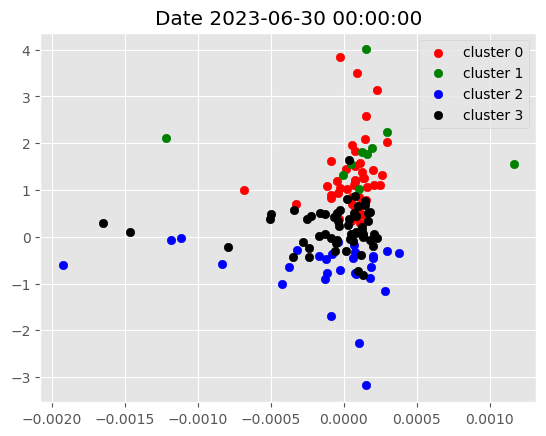

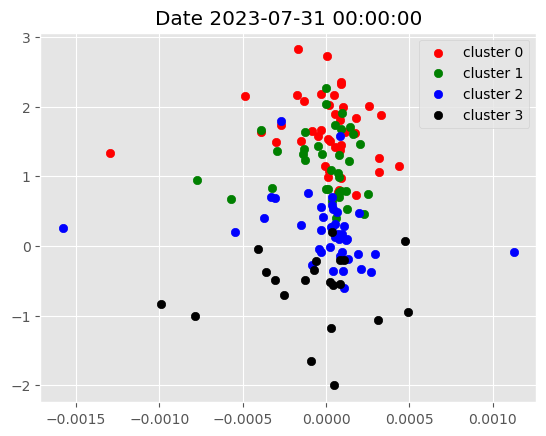

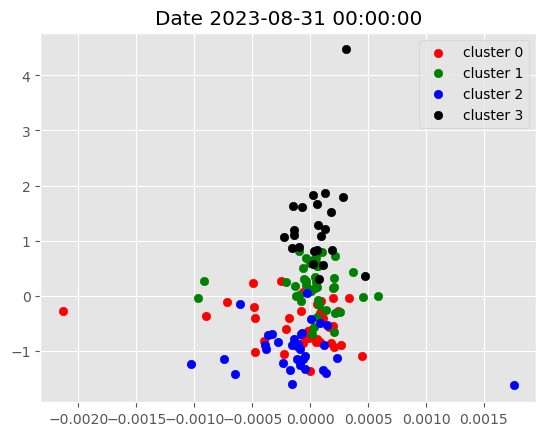

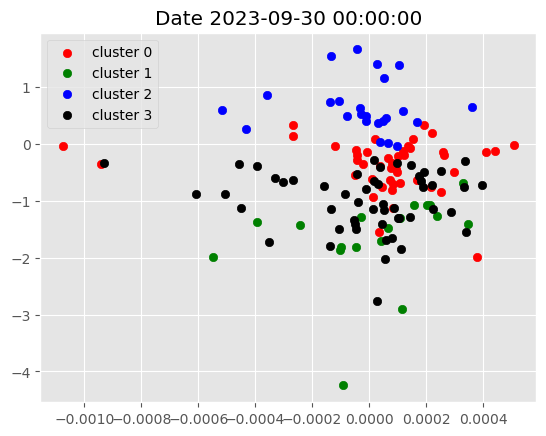

In [50]:
def plot_clusters(data):
    
    cluster_0=data[data['cluster']==0]
    cluster_1=data[data['cluster']==1]
    cluster_2=data[data['cluster']==2]
    cluster_3=data[data['cluster']==3]
    
    plt.scatter(cluster_0.iloc[:,0], cluster_0.iloc[:,6], color='red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0], cluster_1.iloc[:,6], color='green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0], cluster_2.iloc[:,6], color='blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0], cluster_3.iloc[:,6], color='black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return

plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)